In [2]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from torch.utils.data import sampler

%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

%load_ext autoreload
%autoreload 2

In [3]:
NUM_TRAIN = 49000

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))
])

cifar10_train = torchvision.datasets.CIFAR10("../datasets", train=True, 
                transform=transform)

cifar10_test = torchvision.datasets.CIFAR10("../datasets", train=False,
                transform=transform)

loader_train = DataLoader(cifar10_train, batch_size=128,
                sampler=sampler.SubsetRandomSampler(range(NUM_TRAIN)))

loader_val = DataLoader(cifar10_train, batch_size=128, 
                sampler=sampler.SubsetRandomSampler(range(NUM_TRAIN, 50000)))

loader_test = DataLoader(cifar10_test, batch_size=128)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(-0.5, 31.5, 31.5, -0.5)

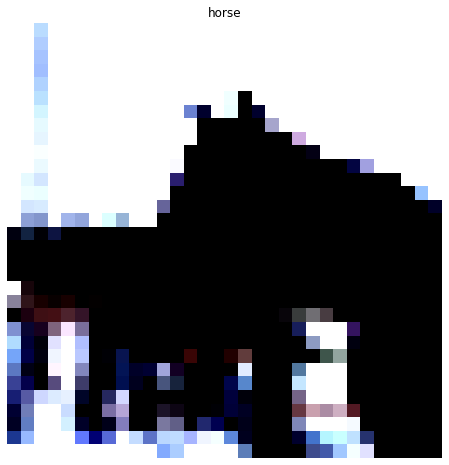

In [4]:
i = 5001
image, target = cifar10_train[i]
plt.imshow(image.permute(1, 2, 0))
plt.title(classes[target])
plt.axis('off')

In [5]:
class VGG(nn.Module):
    def __init__(self):
        super(VGG, self).__init__()

        self.conv = nn.Sequential(
            nn.Conv2d(3, 16, 3, padding=1),
            nn.ReLU(),
            nn.Conv2d(16, 16, 3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(3, stride=1, padding=1),

            nn.Conv2d(16, 32, 3, padding=1),
            nn.ReLU(),
            nn.Conv2d(32, 32, 3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),

            nn.Conv2d(32, 64, 3, padding=1),
            nn.ReLU(),
            nn.Conv2d(64, 64, 3, padding=1),
            nn.ReLU(),
            nn.Conv2d(64, 64, 3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(3, stride=1, padding=1),

            nn.Conv2d(64, 128, 3, padding=1),
            nn.ReLU(),
            nn.Conv2d(128, 128, 3, padding=1),
            nn.ReLU(),
            nn.Conv2d(128, 128, 3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),

            nn.Conv2d(128, 128, 3, padding=1),
            nn.ReLU(),
            nn.Conv2d(128, 128, 3, padding=1),
            nn.ReLU(),
            nn.Conv2d(128, 128, 3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(3, stride=1, padding=1),

            nn.Flatten()
        )

        self.fc = nn.Sequential(
            nn.Linear(128 * 8 * 8, 4096),
            nn.Dropout(0.5),

            nn.Linear(4096, 1024),
            nn.Dropout(0.5),

            nn.Linear(1024, 10)
        )

    def forward(self, x):
        x = self.conv(x)
        x = self.fc(x)

        return x

In [6]:
device = torch.device('cuda')
print("Using:", device)

def check_accuracy(loader, model):
    # if loader.dataset.train:
    #     print('Checking accuracy on validation set')
    # else:
    #     print('Checking accuracy on test set')   

    num_correct = 0
    num_samples = 0

    model.eval()

    with torch.no_grad():
        for x, y in loader:
            x = x.to(device=device)
            y = y.to(device=device)
            scores = model(x)
            _, preds = scores.max(1)
            num_correct += (preds == y).sum()
            num_samples += preds.size(0)
        acc = float(num_correct) / num_samples
        # print('Got %d / %d correct (%.2f)' % (num_correct, num_samples, 100 * acc))
    return acc

def train_model(model, optimizer, loader=loader_train, epochs=10, print_every=100):
    model = model.to(device=device)
    loss_fc = nn.CrossEntropyLoss()
    loss_history = []
    acc_history = []
    for e in range(epochs):
        for t, (x, y) in enumerate(loader):
            model.train()
            x = x.to(device=device)
            y = y.to(device=device)

            optimizer.zero_grad()

            scores = model(x)
            loss = loss_fc(scores, y)

            loss.backward()

            optimizer.step()

            # if t % print_every == 0:
            #     print('Iteration %d, loss = %.4f' % (t, loss.item()))
            #     check_accuracy(loader_val, model)
            #     print()
        
        acc = check_accuracy(loader_val, model)
        print('Epoch {}, loss = {:.4f}, accuracy = {:.2f}%'.format(e, loss.item(), acc * 100))
        # print('Epoch %d, loss = %.4f, accuracy = %.2f\\%' % (e, loss.item(), acc * 100))

        loss_history.append(loss)
        acc_history.append(acc)
    
    return loss_history, acc_history

Using: cuda


In [7]:
learning_rate = 1e-4
model = VGG()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

loss_history, acc_history = train_model(model, optimizer)

Epoch 0, loss = 1.6844, accuracy = 36.80%
Epoch 1, loss = 1.6033, accuracy = 43.70%
Epoch 2, loss = 1.5404, accuracy = 48.30%
Epoch 3, loss = 1.2901, accuracy = 53.50%
Epoch 4, loss = 1.2790, accuracy = 56.90%
Epoch 5, loss = 1.0632, accuracy = 57.50%
Epoch 6, loss = 0.9869, accuracy = 60.20%
Epoch 7, loss = 1.0218, accuracy = 63.50%
Epoch 8, loss = 1.0453, accuracy = 63.80%
Epoch 9, loss = 1.0195, accuracy = 63.80%


Text(0.5, 1.0, 'Training Accuracy history')

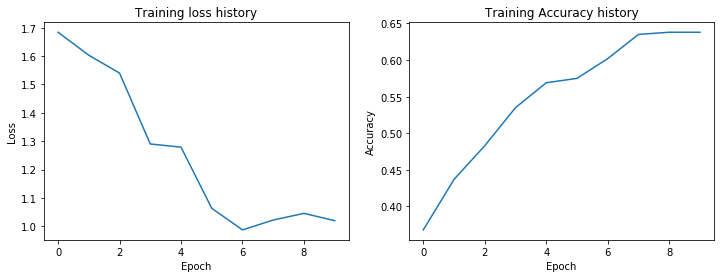

In [8]:
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(loss_history)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training loss history')

plt.subplot(1, 2, 2)
plt.plot(acc_history)
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training Accuracy history')

In [9]:
check_accuracy(loader_test, model)

0.6315

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(-0.5, 31.5, 31.5, -0.5)

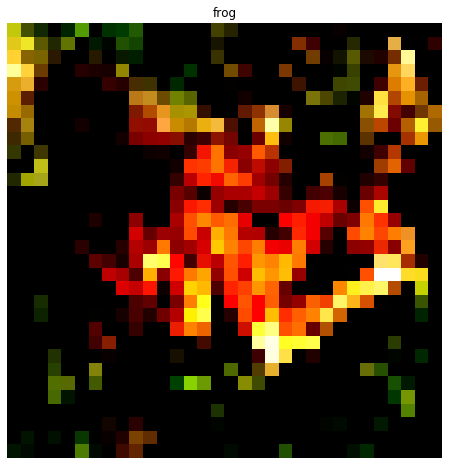

In [10]:
image, target = cifar10_test[i]
plt.imshow(image.permute(1, 2, 0))
plt.title(classes[target])
plt.axis('off')

In [13]:
image = image.to(device=device)
predict = model(image.view(-1, 3, 32, 32))

In [19]:
classes[predict.argmax()]

'frog'